In [1]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

import plotly.graph_objects as go
import numpy as np 
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices

import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from torchvision import transforms
from config import get_sensat_cfg
from model.models import VoxMeshHead

from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Making sparse depths from sample image

706
(5.703207969665527, 25.950923919677734)
65535
(424, 512)
39202


/tmp/ipykernel_2913144/1725205361.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  depth_image = imread('test_data/sample_sparse_depth.png')


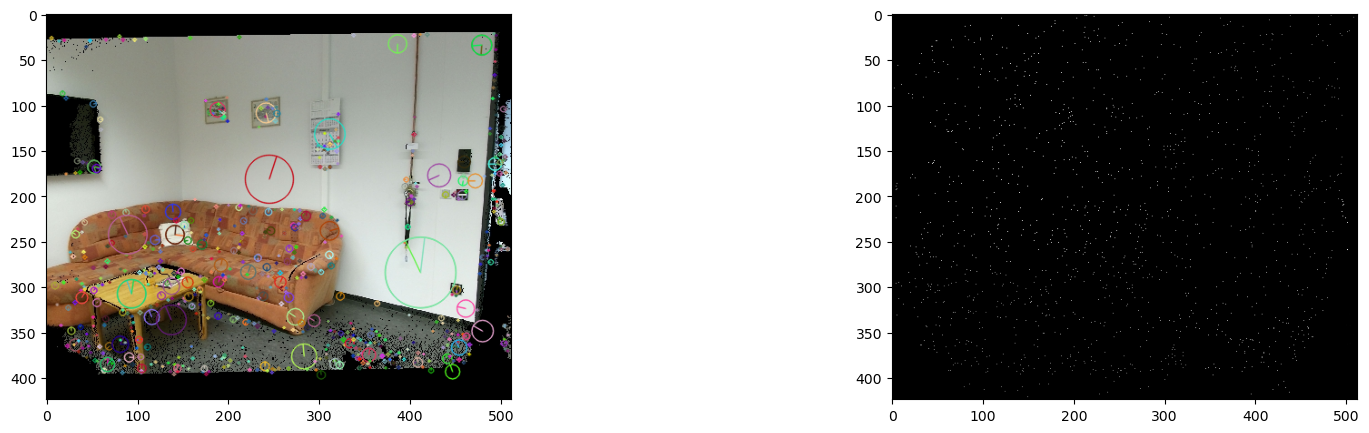

In [92]:
import cv2
import random

image = cv2.imread("test_data/sample_rgb.png")
depth_image = cv2.imread('test_data/sample_depth.png', cv2.IMREAD_UNCHANGED)
# depth_image = cv2.cvtColor(depth_image, cv2.COLOR_BGR2GRAY)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints = sift.detect(gray, None)
keypoint_locations = [kp.pt for kp in keypoints]

print(len(keypoint_locations))
print(keypoint_locations[0])

image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_rgb = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

keypoint_locations_rounded = [np.round(kp.pt).astype(int) for kp in keypoints]
depth_values = [depth_image[loc[1], loc[0]] for loc in keypoint_locations_rounded]
sparse_depth_image = np.zeros_like(depth_image)
for depth, loc in zip(depth_values, keypoint_locations_rounded):
    if depth > 40000 or depth == 0:
        continue
    sparse_depth_image[loc[1], loc[0]] = depth
print(np.max(depth_values))

additional_points = random.sample(list(np.ndindex(depth_image.shape[:2])), k=1000)
for loc in additional_points:
    if depth_image[loc[0], loc[1]] > 40000 or depth == 0:
        continue
    sparse_depth_image[loc[0], loc[1]] = depth_image[loc[0], loc[1]]

# Display the sparse depth image
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))

ax1.imshow(image_with_keypoints_rgb)
ax2.imshow(sparse_depth_image, cmap='gray')

print(sparse_depth_image.shape)
cv2.imwrite('test_data/sample_sparse_depth.png', sparse_depth_image)
depth_image = imread('test_data/sample_sparse_depth.png')
print(np.max(depth_image))

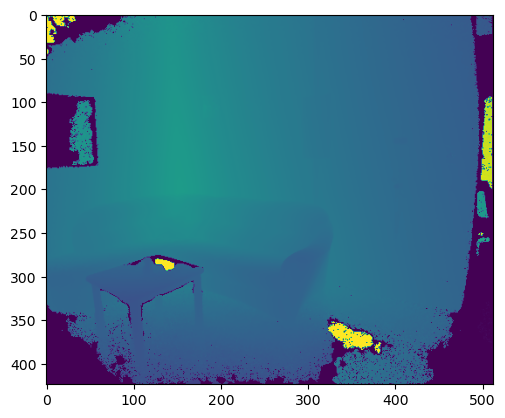

In [95]:
depth_image = cv2.imread('test_data/sample_depth.png', cv2.IMREAD_UNCHANGED)
plt.imshow(depth_image)

# Experimenting with indoor mesh generation

468.796875
531.609375
1.947320580482483


/tmp/ipykernel_3555883/446317686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sparsedepth = imread(sparse_depth_file)/64


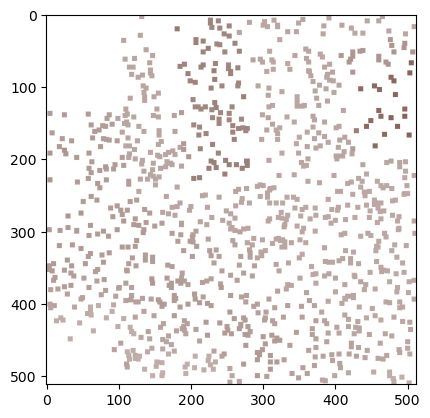

In [124]:
sparse_depth_file = "whu_test/009_67/Pcds_1000_gt/0000.png"
sparsedepth = imread(sparse_depth_file)/64
print(np.min(sparsedepth[sparsedepth > 0]))
print(np.max(sparsedepth))
print(np.mean(sparsedepth))

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,50,600)
plt.imshow(sparsedepth_vis)

/tmp/ipykernel_2351072/4139071979.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imread(rgb_file)
/tmp/ipykernel_2351072/4139071979.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sparsedepth = imread(sparse_depth_file)/depth_scale


300.0
400.0
1.1307619385800118


/tmp/ipykernel_2351072/4139071979.py:31: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_depth = imread(gt_depth_file)/depth_scale


(-0.5, 511.5, 511.5, -0.5)

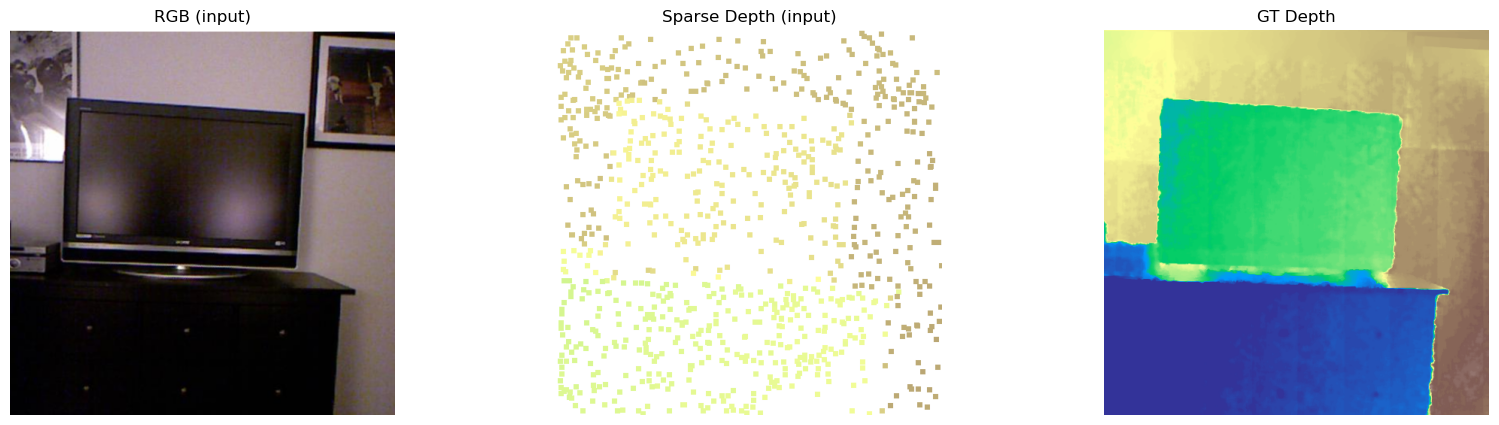

In [2]:
depth_scale = 0.5
depth_min = 50
depth_max = 600

rgb_file = "test_data/tv_192_rgb.png"
sparse_depth_file = "test_data/tv_192_sparse_depth.png"
gt_depth_file = "test_data/tv_192_depth.png"

# Visualize the input data and the groundtruth
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
rgb = imread(rgb_file) 
ax1.imshow(rgb)
ax1.set_title('RGB (input)')
ax1.axis('off')
sparsedepth = imread(sparse_depth_file)/depth_scale
# sparsedepth = sparsedepth[sparsedepth > 100]

nonzero_indices = sparsedepth != 0
nonzero_values = sparsedepth[nonzero_indices]

mapped_values = ((nonzero_values - np.min(nonzero_values)) / (np.max(nonzero_values) - np.min(nonzero_values))) * (400 - 300) + 300
sparsedepth[nonzero_indices] = mapped_values
print(np.min(sparsedepth[sparsedepth > 0]))
print(np.max(sparsedepth))
print(np.mean(sparsedepth))

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
ax2.imshow(sparsedepth_vis)
ax2.set_title('Sparse Depth (input)')
ax2.axis('off')
gt_depth = imread(gt_depth_file)/depth_scale
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')

# Mesh initialization

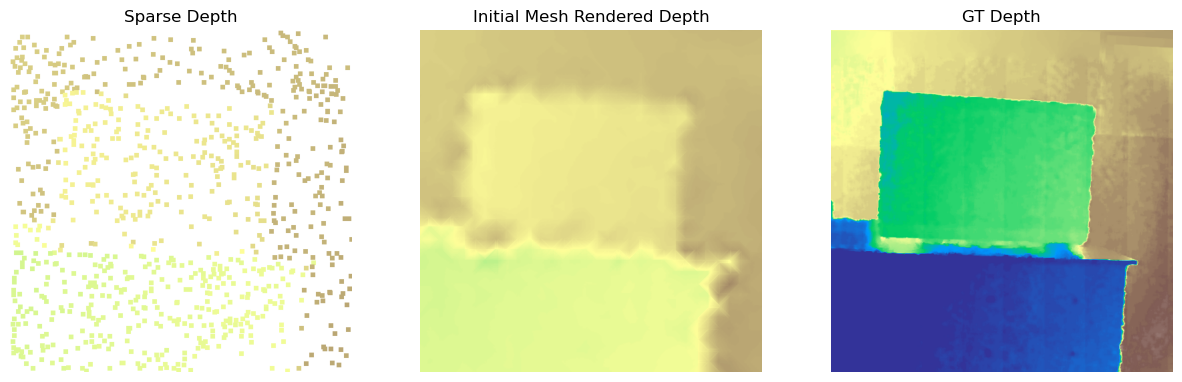

In [10]:
num_mesh_vertices = 1024
image_size = 512
focal_length = -2

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Initialize the mesh using only the sparse depth
init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(sparsedepth_vis)
ax1.set_title('Sparse Depth')
ax1.axis('off')
ax2.imshow(init_mesh_depth_vis)
ax2.set_title('Initial Mesh Rendered Depth')
ax2.axis('off')
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')
plt.show()

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])
# mp.plot(init_mesh_vertices@rotate_matrix, init_mesh_faces, init_mesh_height_color)

# Semantic Segmentation

In [11]:
import meshplot as mp
mp.plot(init_mesh_vertices@rotate_matrix, init_mesh_faces, init_mesh_height_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.3097229…

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0


torch.Size([1, 5, 512, 512])


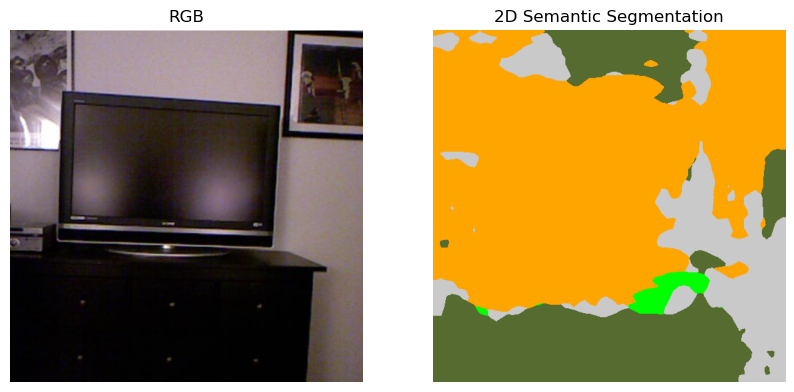

In [12]:
save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]

# print(pred_semantic_features)
print(pred_semantic_features.shape)
pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1.axis('off')
ax2.imshow(pred_semantic_vis)
ax2.set_title('2D Semantic Segmentation')
ax2.axis('off')
plt.show()

# Mesh Refinement

In [13]:
save_model_path = "checkpoints/Sem_Dice/model_best_depth.tar"
device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
sparsedepth_mask = (sparsedepth<=0)*1
depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)

# Normalized the mesh
init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])

# The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
refine_mesh = model(input_img, init_mesh, pred_semantic_features)
refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))

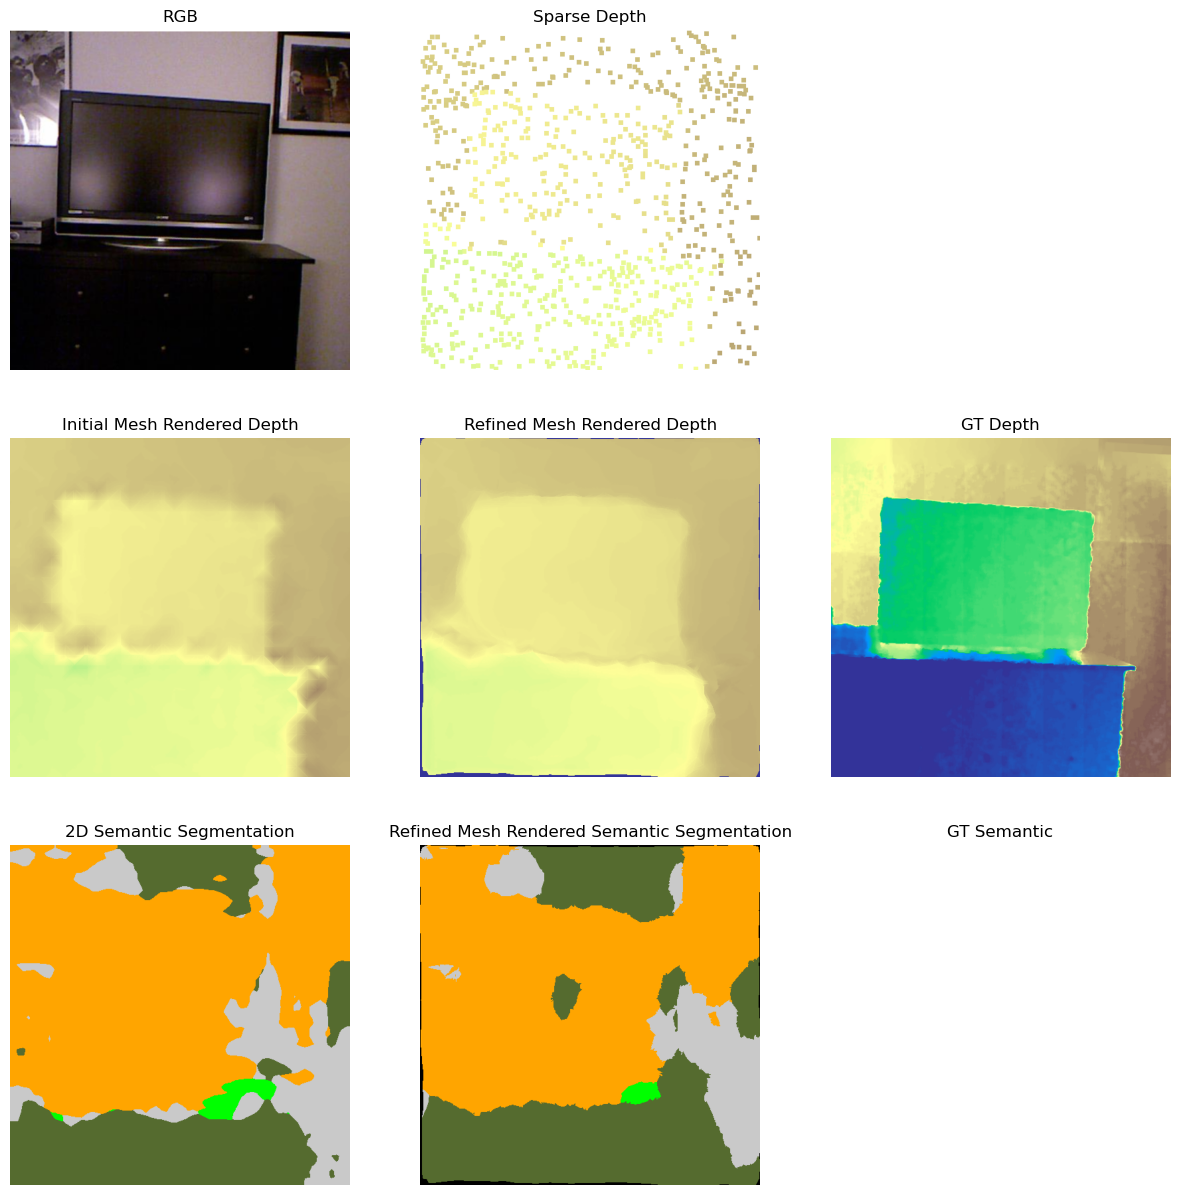

In [14]:
from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

device = torch.device("cuda:0")
image_size = 512
focal_length = -2

refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
refine_mesh_semantic_vis = convert_class_to_rgb_sensat_simplified(refine_mesh_semantic)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')
# ax33.imshow(gt_sem_vis)
ax33.set_title('GT Semantic')
ax33.axis('off')

plt.show()

refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()
refine_mesh_height_color = texture_mesh_vertices(refine_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

In [15]:
mp.plot(refine_mesh_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(6.4442367…